In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
with open('lemmatized_without_stopwords.txt') as f:
    reviewsWithoutStopWords = f.read().splitlines()

reviewsWithoutStopWords[0]

"['jan', 'friendly', 'welcome', 'host', 'apartment', 'great', 'area', 'sooo', 'amaze', 'lot', 'nice', 'cafe', 'shop', 'enjoy', 'time', 'lot']"

In [3]:
reviewsWithoutStopWords = [review.replace('\'', '').strip('][').split(', ')
                           for review in reviewsWithoutStopWords]

reviewsWithoutStopWords[0]

['jan',
 'friendly',
 'welcome',
 'host',
 'apartment',
 'great',
 'area',
 'sooo',
 'amaze',
 'lot',
 'nice',
 'cafe',
 'shop',
 'enjoy',
 'time',
 'lot']

## Bigrams generation

In [4]:
from gensim.models.phrases import Phrases, Phraser

phrasesWithoutStopWords = Phrases(reviewsWithoutStopWords,
                                  min_count=3,
                                  progress_per=50000)

bigramWithoutStopWords = Phraser(phrasesWithoutStopWords)

bigramReviewsWithoutStopWords = bigramWithoutStopWords[reviewsWithoutStopWords]

bigramReviewsWithoutStopWords[0]

d:\utenti\marco\desktop\insubria\laurea magistrale\data mining\airbnb-sentiment\venv\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


['really', 'nice', 'area', 'food', 'park', 'transport', 'perfect']

In [5]:
from collections import defaultdict

dictWordFreq = defaultdict(int)
for review in bigramReviewsWithoutStopWords:
    for i in review:
        dictWordFreq[i] += 1

len(dictWordFreq)

64487

In [ ]:
# Eventually, show an example of item in word_freq

In [6]:
sorted(dictWordFreq, key=dictWordFreq.get, reverse=True)[:10]

['great',
 'apartment',
 'stay',
 'place',
 'berlin',
 'nice',
 'location',
 'host',
 'clean',
 'good']

## Word2Vec model

In [7]:
from gensim.models import Word2Vec

w2vModelWithoutStopWords = Word2Vec(min_count=20,
                             window=4,
                             vector_size=300,
                             sample=6e-5,
                             alpha=0.03,
                             min_alpha=0.0007,
                             negative=20,
                             workers=4)

In [8]:
from time import time

t = time()

w2vModelWithoutStopWords.build_vocab(bigramReviewsWithoutStopWords, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.13 mins


In [9]:
t = time()

w2vModelWithoutStopWords.train(bigramReviewsWithoutStopWords,
                               total_examples=w2vModelWithoutStopWords.corpus_count,
                               epochs=30,
                               report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 5.69 mins


In [10]:
# w2vModelWithoutStopWords.save("word2vec_no_stopwords.model")

## Exploring the model

In [11]:
w2vModelWithoutStopWords.wv.most_similar(positive=["apartment"])

[('flat', 0.6894327998161316),
 ('spacious', 0.5183488130569458),
 ('modern', 0.4726952016353607),
 ('clean', 0.4235592186450958),
 ('studio', 0.4066460132598877),
 ('beautifully_appoint', 0.40020251274108887),
 ('recently_renovate', 0.3892408609390259),
 ('stylishly_decorate', 0.38521313667297363),
 ('amenity', 0.38502761721611023),
 ('light_airy', 0.38435810804367065)]

## Clustering model

In [12]:
from sklearn.cluster import KMeans
import numpy as np

kmeansModel2Clusters = KMeans(n_clusters=2, max_iter=1000, random_state=42, n_init=50)
kmeansModel2Clusters.fit(X=w2vModelWithoutStopWords.wv.vectors.astype('double'))

KMeans(max_iter=1000, n_clusters=2, n_init=50, random_state=42)

In [13]:
w2vModelWithoutStopWords.wv.similar_by_vector(kmeansModel2Clusters.cluster_centers_[0],
                                              topn=10,
                                              restrict_vocab=None)

[('unacceptable', 0.6562420129776001),
 ('due_lack', 0.6510743498802185),
 ('useless', 0.6452800631523132),
 ('replacement', 0.6404633522033691),
 ('wire', 0.6399429440498352),
 ('rug', 0.6363683342933655),
 ('metal', 0.6256919503211975),
 ('disgust', 0.6226676106452942),
 ('trap', 0.6218467950820923),
 ('however', 0.6179028153419495)]

In [14]:
negativeClusterIndex = 0

In [15]:
dfWords2ClustersWithoutStopWords = pd.DataFrame(
    w2vModelWithoutStopWords.wv.key_to_index.keys())

dfWords2ClustersWithoutStopWords.columns = ['words']

dfWords2ClustersWithoutStopWords['vectors'] = \
    dfWords2ClustersWithoutStopWords['words'].apply(
        lambda x: w2vModelWithoutStopWords.wv[f'{x}'])

dfWords2ClustersWithoutStopWords['cluster'] = \
    dfWords2ClustersWithoutStopWords['vectors'].apply(
        lambda x: w2vModelWithoutStopWords.predict([np.array(x)]))

dfWords2ClustersWithoutStopWords['cluster'] = \
    dfWords2ClustersWithoutStopWords['cluster'].apply(
        lambda x: x[0])

dfWords2ClustersWithoutStopWords.head()

,words,vectors,cluster
0,great,"[0.2318326, -0.41356355, -0.38995484, 0.054996...",1
1,apartment,"[0.18243288, -0.25620466, 0.051194306, 0.01662...",1
2,stay,"[0.28195247, 0.38772163, -0.038925134, 0.14130...",1
3,place,"[0.39702508, -0.29538885, 0.04700571, 0.120634...",1
4,berlin,"[-0.012200372, 0.06495952, -0.043543015, -0.23...",1


In [16]:
dfWords2ClustersWithoutStopWords['cluster_value'] = [
    -1 if i==negativeClusterIndex else 1
    for i in dfWords2ClustersWithoutStopWords['cluster']]

dfWords2ClustersWithoutStopWords['closeness_score'] = \
    dfWords2ClustersWithoutStopWords.apply(
        lambda x: 1/(kmeansModel2Clusters.transform([x.vectors]).min()),
        axis=1)

dfWords2ClustersWithoutStopWords['sentiment_coeff'] = \
    dfWords2ClustersWithoutStopWords['closeness_score'] * \
    dfWords2ClustersWithoutStopWords['cluster_value']

dfWords2ClustersWithoutStopWords[
    dfWords2ClustersWithoutStopWords['cluster_value'] == -1].head()

,words,vectors,cluster,cluster_value,closeness_score,sentiment_coeff
11,room,"[-0.36604568, -0.08541794, 0.26281667, 0.56228...",0,-1,0.138173,-0.138173
40,like,"[0.66072285, -0.034582037, 0.16814052, -0.4716...",0,-1,0.129486,-0.129486
45,one,"[-0.5676881, -0.084533446, 0.8584303, -0.08739...",0,-1,0.159863,-0.159863
46,bed,"[-0.7576953, -0.2234998, 0.16871263, 0.2120387...",0,-1,0.108120,-0.108120
47,big,"[-0.6025334, -0.14693871, 0.42892277, 0.477283...",0,-1,0.116142,-0.116142


## TF-IDF

In [17]:
dfCleanedReviewsWithoutStopWords = pd.DataFrame(
    [' '.join(review) for review in reviewsWithoutStopWords],
    columns=['comments'])

dfCleanedReviewsWithoutStopWords.head()

,comments
0,jan friendly welcome host apartment great area...
1,really nice area food park transport perfect
2,nice stay berlin thanks jan premium situate ap...
3,great location close mauerpark kastanienallee ...
4,apartment well locate close everything superma...


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfWithoutStopWords = TfidfVectorizer(norm=None)
transformed = tfidfWithoutStopWords.fit_transform(
    dfCleanedReviewsWithoutStopWords['comments'].tolist())
features = pd.Series(tfidfWithoutStopWords.get_feature_names())

In [19]:
def create_tfidf_dictionary(x, transformed_file, features_file):
    """
    create dictionary for each input sentence x, where each word has assigned its tfidf score

    inspired  by function from this wonderful article:
    https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34

    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer
    """
    # print('Name:', x.name)
    vector_coo = transformed_file[x.name].tocoo()
    vector_coo.col = features_file.iloc[vector_coo.col].values
    dict_from_coo = dict(zip(vector_coo.col, vector_coo.data))
    return dict_from_coo

def replace_tfidf_words(x, transformed_file, features_file):
    """
    replacing each word with it's calculated tfidf dictionary with scores of each word
    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer
    """
    dictionary = create_tfidf_dictionary(x, transformed_file, features_file)
    try:
        res = list(map(lambda y:dictionary[f'{y}'], x['comments'].split()))
    except KeyError:
        res = [0 for i in x['comments'].split()]
    return res

In [20]:
tfidfScoresWithoutStopWords = dfCleanedReviewsWithoutStopWords.apply(
    lambda x: replace_tfidf_words(x, transformed, features), axis=1)
type(tfidfScoresWithoutStopWords)

pandas.core.series.Series

In [21]:
dictSentiment2ClustersWithoutStopWords = dict(zip(
    dfWords2ClustersWithoutStopWords['words'].values,
    dfWords2ClustersWithoutStopWords['sentiment_coeff'].values))

In [22]:

def replace_sentiment_words(word, sentiment_dict):
    """
    replacing each word with its associated sentiment score from sentiment dict
    """
    try:
        out = sentiment_dict[word]
    except KeyError:
        out = 0
    return out

In [23]:
closenessScores2ClustersWithoutStopWords = \
    dfCleanedReviewsWithoutStopWords['comments'].apply(
        lambda x: list(map(
            lambda y: replace_sentiment_words(y, dictSentiment2ClustersWithoutStopWords),
            x.split())))

In [24]:
dfSentiment2ClustersTfidfReviewsWithoutStopWords = \
    pd.DataFrame([closenessScores2ClustersWithoutStopWords,
                  tfidfScoresWithoutStopWords,
                  dfCleanedReviewsWithoutStopWords['comments']]).T

dfSentiment2ClustersTfidfReviewsWithoutStopWords.columns = \
    ['sentiment_coeff', 'tfidf_scores', 'review']

dfSentiment2ClustersTfidfReviewsWithoutStopWords['sentiment_rate'] = \
    dfSentiment2ClustersTfidfReviewsWithoutStopWords.apply(
        lambda x: np.array(x.loc['sentiment_coeff']) @ np.array(x.loc['tfidf_scores']),
        axis=1)

dfSentiment2ClustersTfidfReviewsWithoutStopWords['prediction'] =\
    (dfSentiment2ClustersTfidfReviewsWithoutStopWords['sentiment_rate'] > 0)\
        .astype('int8')

dfSentiment2ClustersTfidfReviewsWithoutStopWords.head()

,sentiment_coeff,tfidf_scores,sentence,sentiment_rate,prediction
0,"[0.08292789117179868, 0.14659773029428852, 0.1...","[6.45518200427728, 3.112217967778944, 3.555659...",jan friendly welcome host apartment great area...,8.077008,1
1,"[0.2140253900223827, 0.1759372378172309, 0.118...","[2.6419108992866036, 2.1582410989662106, 3.154...",really nice area food park transport perfect,2.924775,1
2,"[0.1759372378172309, 0.1749805377874351, 0.144...","[2.1582410989662106, 1.8573260246038177, 2.148...",nice stay berlin thanks jan premium situate ap...,12.992785,1
3,"[0.20017538809786173, 0.16653104339589603, 0.1...","[1.8501655371557688, 2.159718877149754, 2.7123...",great location close mauerpark kastanienallee ...,4.916187,1
4,"[0.18708789271173457, 0.13582535451733493, 0.1...","[3.927308953862587, 2.8408487877668502, 6.4401...",apartment well locate close everything superma...,6.689567,1


In [25]:
dfNegativeSentiment = dfSentiment2ClustersTfidfReviewsWithoutStopWords[
    dfSentiment2ClustersTfidfReviewsWithoutStopWords['prediction'] == 0].sort_values(
        by=['sentiment_rate'])

print('Top-5 negative reviews:')
dfNegativeSentiment['review'].head().tolist()

d:\utenti\marco\desktop\insubria\laurea magistrale\data mining\airbnb-sentiment\venv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


['big flat heart neuk lln min station nice flatmate amazing room day everything fine flat mate nice reccomend every website hide airbnb sure like thanks benjamin sonia luca website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb',
 'one word mouse get apartment find mice run living room bedroom hysteria contact host benjamin respond right away tell us sunday know could nothing could check problem really mice problem tell family small child berlin high season would go tell would contact airbnb change apartment look hotel back forth say would borrow cat friend seem like g

In [58]:
# dfSentiment2ClustersTfidfReviewsWithoutStopWords.to_csv(
#     'sentiment_dataset_2_clusters_no_stopwords.csv',
#     sep=',', index=False, header=True)

inertia_ 1019212.2318113383
inertia_ 978896.6769949866
inertia_ 945585.1195484456
inertia_ 928658.3150795486
inertia_ 916025.811975582
inertia_ 903335.0746483419
inertia_ 893447.0373069287
inertia_ 886049.8955736477
inertia_ 879141.0423535313
inertia_ 872683.0122456265


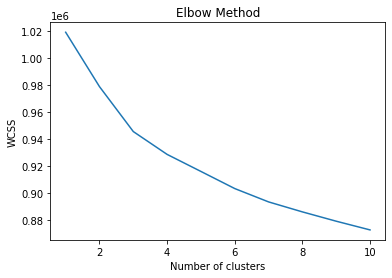

In [27]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X=w2vModelWithoutStopWords.wv.vectors.astype('double'))
    # inertia_ is sum of squared distance of samples to its closest cluster centers.
    wcss.append(kmeans.inertia_)
    print("inertia_", kmeans.inertia_)
    # print("wcss", within_css(kmeans))

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [28]:
from sklearn.metrics import silhouette_score

def kmeans_silhouette(X,range_clusters):
    for i, k in range_clusters :

        # Run the Kmeans algorithm
        km = KMeans(n_clusters = k, init = 'k-means++', random_state = 42)

        km.fit(X)
        labels = km.predict(X)

        print("For n_clusters =", k,
                  "The computed average silhouette_score is :",
              silhouette_score(X, labels, metric='euclidean'))

In [29]:
rangeClusters = enumerate([2,3,4,5,6,7,8,9,10])
kmeans_silhouette(w2vModelWithoutStopWords.wv.vectors.astype('double'), rangeClusters)

For n_clusters = 2 The computed average silhouette_score is : 0.06838657781314701
For n_clusters = 3 The computed average silhouette_score is : 0.05258252258721236
For n_clusters = 4 The computed average silhouette_score is : 0.04920517899962191
For n_clusters = 5 The computed average silhouette_score is : -0.0011381941214056086
For n_clusters = 6 The computed average silhouette_score is : -0.0009612685214078678
For n_clusters = 7 The computed average silhouette_score is : -0.008021767718248312
For n_clusters = 8 The computed average silhouette_score is : -0.004286899803312471
For n_clusters = 9 The computed average silhouette_score is : -0.04467021073991618
For n_clusters = 10 The computed average silhouette_score is : -0.04210330476167779


## 3-clusters

In [31]:
kmeansModel3Clusters = KMeans(n_clusters=3, max_iter=1000, random_state=42, n_init=50)
kmeansModel3Clusters.fit(X=w2vModelWithoutStopWords.wv.vectors.astype('double'))

KMeans(max_iter=1000, n_clusters=3, n_init=50, random_state=42)

In [43]:
w2vModelWithoutStopWords.wv.similar_by_vector(
    kmeansModel3Clusters.cluster_centers_[2], topn=10, restrict_vocab=None)

[('rug', 0.6532878279685974),
 ('useless', 0.6441034078598022),
 ('wire', 0.6389830112457275),
 ('metal', 0.637913167476654),
 ('unacceptable', 0.6357297897338867),
 ('due_lack', 0.6344221830368042),
 ('replacement', 0.6306535005569458),
 ('bathroom', 0.6279341578483582),
 ('shower', 0.620943009853363),
 ('light_fixture', 0.618454098701477)]

In [50]:
negativeClusterIndex = 2
positiveClusterIndex = 0

In [51]:
dfWords3ClustersWithoutStopWords = pd.DataFrame(
    w2vModelWithoutStopWords.wv.key_to_index.keys())

dfWords3ClustersWithoutStopWords.columns = ['words']

dfWords3ClustersWithoutStopWords['vectors'] = \
    dfWords3ClustersWithoutStopWords['words'].apply(
        lambda x: w2vModelWithoutStopWords.wv[f'{x}'])

dfWords3ClustersWithoutStopWords['cluster'] = \
    dfWords3ClustersWithoutStopWords['vectors'].apply(
        lambda x: kmeansModel3Clusters.predict([np.array(x)]))

dfWords3ClustersWithoutStopWords.cluster = \
    dfWords3ClustersWithoutStopWords['cluster'].apply(
        lambda x: x[0])

dfWords3ClustersWithoutStopWords.head()

,words,vectors,cluster
0,great,"[0.2318326, -0.41356355, -0.38995484, 0.054996...",1
1,apartment,"[0.18243288, -0.25620466, 0.051194306, 0.01662...",1
2,stay,"[0.28195247, 0.38772163, -0.038925134, 0.14130...",1
3,place,"[0.39702508, -0.29538885, 0.04700571, 0.120634...",1
4,berlin,"[-0.012200372, 0.06495952, -0.043543015, -0.23...",0


In [52]:
dfWords3ClustersWithoutStopWords['cluster_value'] = \
    [-1 if i==negativeClusterIndex
     else 1 if i==positiveClusterIndex else 0
     for i in dfWords3ClustersWithoutStopWords['cluster']]

dfWords3ClustersWithoutStopWords['closeness_score'] = \
    dfWords3ClustersWithoutStopWords.apply(
        lambda x: 1/(kmeansModel3Clusters.transform([x.vectors]).min()),
        axis=1)

dfWords3ClustersWithoutStopWords['sentiment_coeff'] = \
    dfWords3ClustersWithoutStopWords['closeness_score'] * \
    dfWords3ClustersWithoutStopWords['cluster_value']

dfWords3ClustersWithoutStopWords[
    dfWords3ClustersWithoutStopWords['cluster_value'] == -1].head()

,words,vectors,cluster,cluster_value,closeness_score,sentiment_coeff
11,room,"[-0.36604568, -0.08541794, 0.26281667, 0.56228...",2,-1,0.141049,-0.141049
18,comfortable,"[-0.32571805, -0.03460458, -0.044151783, 0.333...",2,-1,0.143153,-0.143153
20,need,"[0.26455298, 0.08572723, 0.47097304, 0.5727650...",2,-1,0.130251,-0.130251
40,like,"[0.66072285, -0.034582037, 0.16814052, -0.4716...",2,-1,0.130875,-0.130875
45,one,"[-0.5676881, -0.084533446, 0.8584303, -0.08739...",2,-1,0.159071,-0.159071


In [53]:
dictSentiment3ClustersWithoutStopWords = dict(zip(
    dfWords3ClustersWithoutStopWords['words'].values,
    dfWords3ClustersWithoutStopWords['sentiment_coeff'].values))

In [54]:
closenessScores3ClustersWithoutStopWords = \
    dfCleanedReviewsWithoutStopWords['comments'].apply(
        lambda x: list(map(
            lambda y: replace_sentiment_words(y, dictSentiment3ClustersWithoutStopWords),
            x.split())))

In [55]:
dfSentiment3ClustersTfidfReviewsWithoutStopWords = pd.DataFrame(
    [closenessScores3ClustersWithoutStopWords,
     tfidfScoresWithoutStopWords,
     dfCleanedReviewsWithoutStopWords['comments']]).T

dfSentiment3ClustersTfidfReviewsWithoutStopWords.columns = \
    ['sentiment_coeff', 'tfidf_scores', 'review']

dfSentiment3ClustersTfidfReviewsWithoutStopWords['sentiment_rate'] = \
    dfSentiment3ClustersTfidfReviewsWithoutStopWords.apply(
        lambda x: np.array(x.loc['sentiment_coeff']) @ np.array(x.loc['tfidf_scores']),
        axis=1)

dfSentiment3ClustersTfidfReviewsWithoutStopWords['prediction'] = \
    (dfSentiment3ClustersTfidfReviewsWithoutStopWords['sentiment_rate']>0)\
        .astype('int8')

dfSentiment3ClustersTfidfReviewsWithoutStopWords.head()

,sentiment_coeff,tfidf_scores,sentence,sentiment_rate,prediction
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1505729803885...","[6.45518200427728, 3.112217967778944, 3.555659...",jan friendly welcome host apartment great area...,3.190171,1
1,"[0.0, 0.0, 0.15057298038858502, 0.094984880778...","[2.6419108992866036, 2.1582410989662106, 3.154...",really nice area food park transport perfect,1.718151,1
2,"[0.0, 0.0, 0.14180768378448597, 0.0, 0.0, -0.1...","[2.1582410989662106, 1.8573260246038177, 2.148...",nice stay berlin thanks jan premium situate ap...,4.935444,1
3,"[0.0, 0.19859402114984503, 0.14351576345021688...","[1.8501655371557688, 2.159718877149754, 2.7123...",great location close mauerpark kastanienallee ...,4.189321,1
4,"[0.0, 0.13010846637642784, 0.13745346635416864...","[3.927308953862587, 2.8408487877668502, 6.4401...",apartment well locate close everything superma...,2.252799,1


In [ ]:
# dfSentiment3ClustersTfidfReviewsWithoutStopWords.to_csv(
#     'sentiment_dataset_3_clusters_no_stopwords.csv',
#     sep=',', index=False, header=True)

In [57]:
dfNegativeSentiment = dfSentiment3ClustersTfidfReviewsWithoutStopWords[
    dfSentiment3ClustersTfidfReviewsWithoutStopWords['prediction'] == 0].sort_values(
        by=['sentiment_rate'], inplace=True)

dfNegativeSentiment['review'].head().tolist()

d:\utenti\marco\desktop\insubria\laurea magistrale\data mining\airbnb-sentiment\venv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


['big flat heart neuk lln min station nice flatmate amazing room day everything fine flat mate nice reccomend every website hide airbnb sure like thanks benjamin sonia luca website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb website hide airbnb',
 'one word mouse get apartment find mice run living room bedroom hysteria contact host benjamin respond right away tell us sunday know could nothing could check problem really mice problem tell family small child berlin high season would go tell would contact airbnb change apartment look hotel back forth say would borrow cat friend seem like g

## TextBlob

In [59]:
from textblob import TextBlob

In [61]:
textblobSentimentWithoutStopWords = dfCleanedReviewsWithoutStopWords['comments'].apply(
    lambda x: TextBlob(x).sentiment.polarity)

textblobSentimentWithoutStopWords.head()

0    0.595000
1    0.800000
2    0.487500
3    0.587500
4    0.229762
Name: comments, dtype: float64

In [70]:
dfSentiment3ClustersTfidfReviewsWithoutStopWords['textblob_sentiment'] = \
    textblobSentimentWithoutStopWords

dfSentiment3ClustersTfidfReviewsWithoutStopWords['textblob_prediction'] = \
    (dfSentiment3ClustersTfidfReviewsWithoutStopWords['textblob_sentiment'] > 0)\
        .astype('int8')

dfSentiment3ClustersTfidfReviewsWithoutStopWords.head()

,sentiment_coeff,tfidf_scores,sentence,sentiment_rate,prediction,Textblob Sentiment,Textblob Prediction
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1505729803885...","[6.45518200427728, 3.112217967778944, 3.555659...",jan friendly welcome host apartment great area...,3.190171,1,0.595000,1
1,"[0.0, 0.0, 0.15057298038858502, 0.094984880778...","[2.6419108992866036, 2.1582410989662106, 3.154...",really nice area food park transport perfect,1.718151,1,0.800000,1
2,"[0.0, 0.0, 0.14180768378448597, 0.0, 0.0, -0.1...","[2.1582410989662106, 1.8573260246038177, 2.148...",nice stay berlin thanks jan premium situate ap...,4.935444,1,0.487500,1
3,"[0.0, 0.19859402114984503, 0.14351576345021688...","[1.8501655371557688, 2.159718877149754, 2.7123...",great location close mauerpark kastanienallee ...,4.189321,1,0.587500,1
4,"[0.0, 0.13010846637642784, 0.13745346635416864...","[3.927308953862587, 2.8408487877668502, 6.4401...",apartment well locate close everything superma...,2.252799,1,0.229762,1


## Sentiment Analysis Evaluation

In [77]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

def compute_test_scores(predictions, labels):

    df_conf_matrix = pd.DataFrame(confusion_matrix(predictions, labels))

    print(df_conf_matrix)

    test_scores = accuracy_score(predictions, labels), \
                  precision_score(predictions, labels), \
                  recall_score(predictions, labels), \
                  f1_score(predictions, labels)

    return test_scores


 
 Scores


,scores
accuracy,0.585589
precision,0.583074
recall,0.991731
f1,0.734380


In [1]:
testScores2ClustersSentiment = compute_test_scores(
    dfSentiment2ClustersTfidfReviewsWithoutStopWords['prediction'],
    dfSentiment2ClustersTfidfReviewsWithoutStopWords['textblob_sentiment'])

dfTestScores2ClustersSentiment = pd.DataFrame([testScores2ClustersSentiment])
dfTestScores2ClustersSentiment.columns = ['accuracy', 'precision', 'recall', 'f1']
dfTestScores2ClustersSentiment = dfTestScores2ClustersSentiment.T
dfTestScores2ClustersSentiment.columns = ['scores']

print('Scores for sentiment analysis with 2 clusters and no stopwords: ')
dfTestScores2ClustersSentiment

NameError: name 'compute_test_scores' is not defined

In [ ]:
testScores3ClustersSentiment = compute_test_scores(
    dfSentiment3ClustersTfidfReviewsWithoutStopWords['prediction'],
    dfSentiment3ClustersTfidfReviewsWithoutStopWords['textblob_sentiment'])

dfTestScores3ClustersSentiment = pd.DataFrame([testScores3ClustersSentiment])
dfTestScores3ClustersSentiment.columns = ['accuracy', 'precision', 'recall', 'f1']
dfTestScores3ClustersSentiment = dfTestScores3ClustersSentiment.T
dfTestScores3ClustersSentiment.columns = ['scores']

print('Scores for sentiment analysis with 3 clusters and no stopwords: ')
dfTestScores3ClustersSentiment
